<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch04_stochastic_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

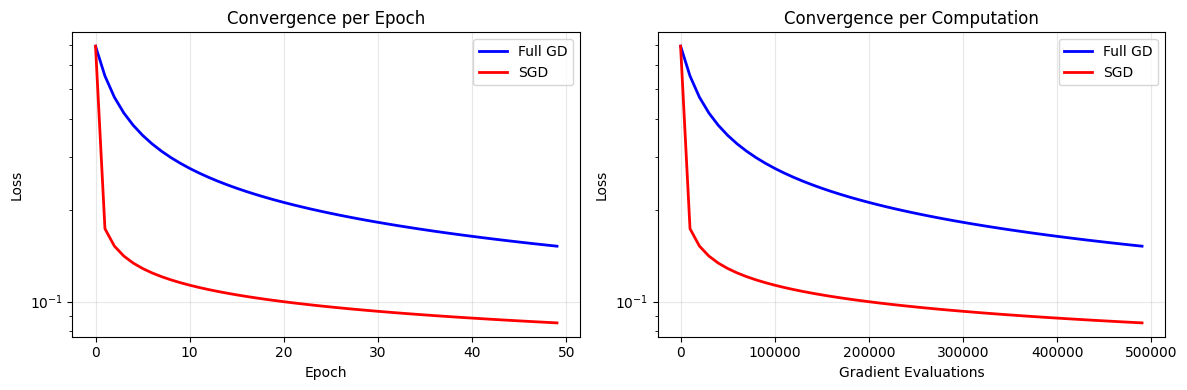

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class SGDOptimizer:
    """SGD with optional momentum and various step size schedules."""

    def __init__(self, eta0=0.1, schedule='constant', momentum=0.0):
        self.eta0 = eta0
        self.schedule = schedule
        self.momentum = momentum
        self.velocity = None

    def get_lr(self, k, K):
        """Get learning rate at iteration k of K total."""
        if self.schedule == 'constant':
            return self.eta0
        elif self.schedule == 'sqrt':
            return self.eta0 / np.sqrt(k + 1)
        elif self.schedule == 'linear':
            return self.eta0 / (k + 1)
        elif self.schedule == 'cosine':
            return self.eta0 * 0.5 * (1 + np.cos(np.pi * k / K))
        else:
            raise ValueError(f"Unknown schedule: {self.schedule}")
    def step(self, x, grad, k, K):
        """Perform one SGD step."""
        eta = self.get_lr(k, K)

        if self.velocity is None:
            self.velocity = np.zeros_like(x)

        self.velocity = self.momentum * self.velocity + grad
        return x - eta * self.velocity

def sgd_experiment():
    """Compare SGD with full GD on logistic regression."""
    np.random.seed(42)

    # Generate data
    n, d = 10000, 50
    X = np.random.randn(n, d)
    w_true = np.random.randn(d)
    y = (1 / (1 + np.exp(-X @ w_true)) > 0.5).astype(float)

    # Logistic loss and gradients
    def sigmoid(z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def full_loss(w):
        p = sigmoid(X @ w)
        return -np.mean(y * np.log(p + 1e-10) + (1-y) * np.log(1-p + 1e-10))

    def full_grad(w):
        p = sigmoid(X @ w)
        return X.T @ (p - y) / n

    def stochastic_grad(w, idx):
        p = sigmoid(X[idx] @ w)
        return X[idx].reshape(-1, 1) @ np.atleast_2d(p - y[idx])

    # Run full GD
    w_gd = np.zeros(d)
    eta_gd = 1.0
    losses_gd = []
    grad_evals_gd = []
    total_grads = 0

    for epoch in range(50):
        losses_gd.append(full_loss(w_gd))
        grad_evals_gd.append(total_grads)
        w_gd = w_gd - eta_gd * full_grad(w_gd)
        total_grads += n

    # Run SGD
    w_sgd = np.zeros(d)
    losses_sgd = []
    grad_evals_sgd = []
    total_grads = 0
    batch_size = 32

    for epoch in range(50):
        losses_sgd.append(full_loss(w_sgd))
        grad_evals_sgd.append(total_grads)

        perm = np.random.permutation(n)
        for start in range(0, n, batch_size):
            idx = perm[start:start+batch_size]
            p = sigmoid(X[idx] @ w_sgd)
            grad = X[idx].T @ (p - y[idx]) / len(idx)

            k = epoch * (n // batch_size) + start // batch_size
            eta = 1.0 / np.sqrt(k + 1)
            w_sgd = w_sgd - eta * grad
            total_grads += len(idx)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].semilogy(losses_gd, 'b-', linewidth=2, label='Full GD')
    axes[0].semilogy(losses_sgd, 'r-', linewidth=2, label='SGD')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Convergence per Epoch')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].semilogy(grad_evals_gd, losses_gd, 'b-', linewidth=2, label='Full GD')
    axes[1].semilogy(grad_evals_sgd, losses_sgd, 'r-', linewidth=2, label='SGD')
    axes[1].set_xlabel('Gradient Evaluations')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Convergence per Computation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('sgd_vs_fullgd.pdf', bbox_inches='tight')
    plt.show()

sgd_experiment()